In [1]:
import nipype
import os,glob,sys,shutil
import nipype.interfaces.fsl as fsl
import nipype.pipeline.engine as pe
import nipype.interfaces.utility as util
import nipype.interfaces.io as nio
from IPython.display import Image

In [2]:
subjRootDir = "/data/HCP_BedpostData/"

FULL_SUBJECT_LIST = [x for x in os.listdir(subjRootDir) if os.path.isdir( subjRootDir+x)]
print(len(FULL_SUBJECT_LIST),"Subjects are potentially available to be processed!")

899 Subjects are potentially available to be processed!


In [ ]:
### Sample Subject = /HCP_Data/HCP_BedpostData/106016/T1w/Diffusion.bedpostX


In [3]:
subject_id_infosource = pe.Node(util.IdentityInterface(fields=['subject_id']),
                                name='subject_id_infosource')
subject_id_infosource.iterables = ('subject_id', FULL_SUBJECT_LIST)

In [4]:
datasource = pe.Node(interface=nio.DataGrabber(infields=['subject_id'],
                                               outfields=['dwi', 'bvec', 'bval']),
                                                 name='datasource')
datasource.inputs.base_directory = subjRootDir 
datasource.inputs.sort_filelist = True
datasource.inputs.template = '%s/T1w/Diffusion/%s'
datasource.inputs.template_args = dict(dwi=[['subject_id', 'data.nii.gz']],
                                       bvecs=[['subject_id', 'bvecs']],
                                       bvals=[['subject_id', 'bvals']],
                                       nodif_brain_mask=[['subject_id','nodif_brain_mask.nii.gz']])
## Just mapped each subject to the corresponding bvec,bvals, brain mask and preprocessed DWI data
### Create the Node for DTIFIT
dtifit = pe.Node(interface=fsl.DTIFit(), name='dtifit')


gen_fa = pe.Workflow(name="gen_fa")
gen_fa.base_dir = '/data/NipypeScratch/'
gen_fa.connect(subject_id_infosource, 'subject_id', datasource, 'subject_id')

gen_fa.connect(subject_id_infosource, 'subject_id', dtifit, 'base_name')
gen_fa.connect(datasource, 'bvecs', dtifit, 'bvecs')
gen_fa.connect(datasource, 'bvals', dtifit, 'bvals')
gen_fa.connect(datasource, 'nodif_brain_mask', dtifit, 'mask')
gen_fa.connect(datasource, 'dwi', dtifit, 'dwi')

In [5]:
datasink = pe.Node(interface=nio.DataSink(), name="datasink")
datasink.inputs.base_directory = os.path.join('/data/NipypeScratch/',
                                              'dtifit_results')
datasink.inputs.parameterization = False
gen_fa.connect(dtifit, 'FA', datasink, 'FA')
gen_fa.connect(dtifit, 'MD', datasink, 'MD')
gen_fa.connect(dtifit, 'V1', datasink, 'V1')
gen_fa.connect(dtifit, 'V2', datasink, 'V2')
gen_fa.connect(dtifit, 'V3', datasink, 'V3')
gen_fa.connect(dtifit, 'L1', datasink, 'L1')
gen_fa.connect(dtifit, 'L2', datasink, 'L2')
gen_fa.connect(dtifit, 'L3', datasink, 'L3')



# tifit/947668_FA.nii.gz
# ./_subject_id_947668/dtifit/947668_S0.nii.gz
# ./_subject_id_947668/dtifit/947668_MO.nii.gz
# ./_subject_id_947668/dtifit/947668_V1.nii.gz
# ./_subject_id_947668/dtifit/947668_V2.nii.gz
# ./_subject_id_947668/dtifit/947668_V3.nii.gz
# ./_subject_id_947668/dtifit/947668_L1.nii.gz
# ./_subject_id_947668/dtifit/947668_L2.nii.gz
# ./_subject_id_947668/dtifit/947668_L3.nii.gz
# ./_subject_id_947668/dtifit/947668_MD.nii.gz


180731-17:53:12,617 workflow INFO:
	 Generated workflow graph: /data/NipypeScratch/gen_fa/graph.png (graph2use=colored, simple_form=False).
/data/NipypeScratch/gen_fa/graph.png


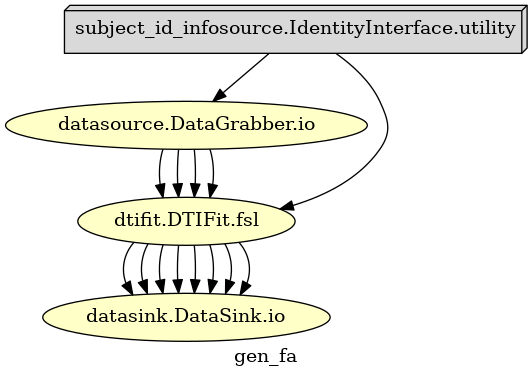

In [6]:
print(gen_fa.write_graph(graph2use='colored',simple_form=False))
Image('/data/NipypeScratch/gen_fa/graph.png')
#Image('/data/HCP_Data/NipypeScratch/gen_fa/graph.png')

In [ ]:
gen_fa.run(plugin='MultiProc', plugin_args={'n_procs' : 10})


180731-17:53:17,902 workflow INFO:
	 Workflow gen_fa settings: ['check', 'execution', 'logging', 'monitoring']
180731-17:53:24,791 workflow INFO:
	 Running in parallel.
180731-17:53:24,964 workflow INFO:
	 [MultiProc] Running 0 tasks, and 899 jobs ready. Free memory (GB): 169.98/169.98, Free processors: 10/10.
180731-17:53:25,24 workflow INFO:
	 [Node] Setting-up "gen_fa.datasource" in "/data/NipypeScratch/gen_fa/_subject_id_662551/datasource".
180731-17:53:25,27 workflow INFO:
	 [Node] Setting-up "gen_fa.datasource" in "/data/NipypeScratch/gen_fa/_subject_id_650746/datasource".
180731-17:53:25,31 workflow INFO:
	 [Node] Setting-up "gen_fa.datasource" in "/data/NipypeScratch/gen_fa/_subject_id_611231/datasource".
180731-17:53:25,36 workflow INFO:
	 [Node] Setting-up "gen_fa.datasource" in "/data/NipypeScratch/gen_fa/_subject_id_580751/datasource".
180731-17:53:25,40 workflow INFO:
	 [Node] Running "datasource" ("nipype.interfaces.io.DataGrabber")180731-17:53:25,39 workflow INFO:
	 [Nod

180731-17:53:26,910 workflow ERROR:
	 Node datasource.a895 failed to run on host 2d0a06a7626b.
180731-17:53:26,912 workflow ERROR:
	 Saving crash info to /data/Scripts/GutmanLabNipypeWorkflows/HCP_Pipelines/crash-20180731-175326-neuro-datasource.a895-ffaef7f7-a9c0-4c24-8c60-c5de0a969181.pklz
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/nipype/pipeline/plugins/multiproc.py", line 68, in run_node
    result['result'] = node.run(updatehash=updatehash)
  File "/opt/conda/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 480, in run
    result = self._run_interface(execute=True)
  File "/opt/conda/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 564, in _run_interface
    return self._run_command(execute)
  File "/opt/conda/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 644, in _run_command
    result = self._interface.run(cwd=outdir)
  File "/opt/conda/lib/python3.6/site-packages/nipype/interfaces/b

180731-17:53:26,946 workflow ERROR:
	 Node datasource.a889 failed to run on host 2d0a06a7626b.
180731-17:53:26,947 workflow ERROR:
	 Saving crash info to /data/Scripts/GutmanLabNipypeWorkflows/HCP_Pipelines/crash-20180731-175326-neuro-datasource.a889-4f61061e-602a-4281-8ac0-07baf5e2cab1.pklz
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/nipype/pipeline/plugins/multiproc.py", line 68, in run_node
    result['result'] = node.run(updatehash=updatehash)
  File "/opt/conda/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 480, in run
    result = self._run_interface(execute=True)
  File "/opt/conda/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 564, in _run_interface
    return self._run_command(execute)
  File "/opt/conda/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 644, in _run_command
    result = self._interface.run(cwd=outdir)
  File "/opt/conda/lib/python3.6/site-packages/nipype/interfaces/b

180731-17:53:28,904 workflow ERROR:
	 Node datasource.a886 failed to run on host 2d0a06a7626b.
180731-17:53:28,906 workflow ERROR:
	 Saving crash info to /data/Scripts/GutmanLabNipypeWorkflows/HCP_Pipelines/crash-20180731-175328-neuro-datasource.a886-d192bebd-7590-4d6c-b15c-b9334f16ba03.pklz
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/nipype/pipeline/plugins/multiproc.py", line 68, in run_node
    result['result'] = node.run(updatehash=updatehash)
  File "/opt/conda/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 480, in run
    result = self._run_interface(execute=True)
  File "/opt/conda/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 564, in _run_interface
    return self._run_command(execute)
  File "/opt/conda/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 644, in _run_command
    result = self._interface.run(cwd=outdir)
  File "/opt/conda/lib/python3.6/site-packages/nipype/interfaces/b

180731-17:53:28,940 workflow ERROR:
	 Node datasource.a880 failed to run on host 2d0a06a7626b.
180731-17:53:28,941 workflow ERROR:
	 Saving crash info to /data/Scripts/GutmanLabNipypeWorkflows/HCP_Pipelines/crash-20180731-175328-neuro-datasource.a880-0b8081a5-a77d-438c-928f-c51a795cecdb.pklz
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/nipype/pipeline/plugins/multiproc.py", line 68, in run_node
    result['result'] = node.run(updatehash=updatehash)
  File "/opt/conda/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 480, in run
    result = self._run_interface(execute=True)
  File "/opt/conda/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 564, in _run_interface
    return self._run_command(execute)
  File "/opt/conda/lib/python3.6/site-packages/nipype/pipeline/engine/nodes.py", line 644, in _run_command
    result = self._interface.run(cwd=outdir)
  File "/opt/conda/lib/python3.6/site-packages/nipype/interfaces/b

180731-17:53:38,979 workflow INFO:
	 [Node] Setting-up "gen_fa.datasink" in "/data/NipypeScratch/gen_fa/_subject_id_910443/datasink".
180731-17:53:38,994 workflow INFO:
	 [Node] Setting-up "gen_fa.datasink" in "/data/NipypeScratch/gen_fa/_subject_id_894673/datasink".180731-17:53:38,994 workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")

180731-17:53:39,5 workflow INFO:
	 [Node] Setting-up "gen_fa.datasink" in "/data/NipypeScratch/gen_fa/_subject_id_894067/datasink".180731-17:53:39,6 workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")180731-17:53:39,6 workflow INFO:
	 [Node] Finished "gen_fa.datasink".


180731-17:53:39,17 workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")180731-17:53:39,18 workflow INFO:
	 [Node] Setting-up "gen_fa.datasink" in "/data/NipypeScratch/gen_fa/_subject_id_878776/datasink".180731-17:53:39,18 workflow INFO:
	 [Node] Finished "gen_fa.datasink".


180731-17:53:39,30 workflow INFO:
	 [N

180731-17:53:43,61 workflow INFO:
	 [Job 133] Cached (gen_fa.dtifit).
180731-17:53:43,76 workflow INFO:
	 [Job 136] Cached (gen_fa.dtifit).
180731-17:53:43,92 workflow INFO:
	 [Job 139] Cached (gen_fa.dtifit).
180731-17:53:43,107 workflow INFO:
	 [Job 142] Cached (gen_fa.dtifit).
180731-17:53:43,118 workflow INFO:
	 [Job 145] Cached (gen_fa.dtifit).
180731-17:53:43,131 workflow INFO:
	 [Job 148] Cached (gen_fa.dtifit).
180731-17:53:44,986 workflow INFO:
	 [Node] Setting-up "gen_fa.datasink" in "/data/NipypeScratch/gen_fa/_subject_id_820745/datasink".
180731-17:53:44,999 workflow INFO:
	 [Node] Setting-up "gen_fa.datasink" in "/data/NipypeScratch/gen_fa/_subject_id_814649/datasink".180731-17:53:44,999 workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")

180731-17:53:45,10 workflow INFO:
	 [Node] Setting-up "gen_fa.datasink" in "/data/NipypeScratch/gen_fa/_subject_id_800941/datasink".180731-17:53:45,11 workflow INFO:
	 [Node] Running "datasink" ("nipype.interface

180731-17:53:48,965 workflow INFO:
	 [MultiProc] Running 0 tasks, and 849 jobs ready. Free memory (GB): 169.98/169.98, Free processors: 10/10.
180731-17:53:49,56 workflow INFO:
	 [Job 151] Cached (gen_fa.dtifit).
180731-17:53:49,64 workflow INFO:
	 [Job 154] Cached (gen_fa.dtifit).
180731-17:53:49,73 workflow INFO:
	 [Job 157] Cached (gen_fa.dtifit).
180731-17:53:49,84 workflow INFO:
	 [Job 160] Cached (gen_fa.dtifit).
180731-17:53:49,98 workflow INFO:
	 [Job 163] Cached (gen_fa.dtifit).
180731-17:53:49,110 workflow INFO:
	 [Job 166] Cached (gen_fa.dtifit).
180731-17:53:49,125 workflow INFO:
	 [Job 169] Cached (gen_fa.dtifit).
180731-17:53:49,140 workflow INFO:
	 [Job 172] Cached (gen_fa.dtifit).
180731-17:53:49,153 workflow INFO:
	 [Job 175] Cached (gen_fa.dtifit).
180731-17:53:49,169 workflow INFO:
	 [Job 178] Cached (gen_fa.dtifit).
180731-17:53:50,992 workflow INFO:
	 [Node] Setting-up "gen_fa.datasink" in "/data/NipypeScratch/gen_fa/_subject_id_748258/datasink".
180731-17:53:51,5 

180731-17:53:54,933 workflow INFO:
	 [Job 192] Completed (gen_fa.datasource).
180731-17:53:54,937 workflow INFO:
	 [Job 195] Completed (gen_fa.datasource).
180731-17:53:54,941 workflow INFO:
	 [Job 198] Completed (gen_fa.datasource).
180731-17:53:54,946 workflow INFO:
	 [Job 201] Completed (gen_fa.datasource).
180731-17:53:54,950 workflow INFO:
	 [Job 204] Completed (gen_fa.datasource).
180731-17:53:54,954 workflow INFO:
	 [Job 207] Completed (gen_fa.datasource).
180731-17:53:54,968 workflow INFO:
	 [MultiProc] Running 0 tasks, and 839 jobs ready. Free memory (GB): 169.98/169.98, Free processors: 10/10.
180731-17:53:55,60 workflow INFO:
	 [Job 181] Cached (gen_fa.dtifit).
180731-17:53:55,71 workflow INFO:
	 [Job 184] Cached (gen_fa.dtifit).
180731-17:53:55,82 workflow INFO:
	 [Job 187] Cached (gen_fa.dtifit).
180731-17:53:55,94 workflow INFO:
	 [Job 190] Cached (gen_fa.dtifit).
180731-17:53:55,108 workflow INFO:
	 [Job 193] Cached (gen_fa.dtifit).
180731-17:53:55,121 workflow INFO:
	 [

	 [Node] Finished "gen_fa.datasource".
180731-17:53:59,98 workflow INFO:
	 [Node] Finished "gen_fa.datasource".
180731-17:54:00,916 workflow INFO:
	 [Job 210] Completed (gen_fa.datasource).
180731-17:54:00,921 workflow INFO:
	 [Job 213] Completed (gen_fa.datasource).
180731-17:54:00,925 workflow INFO:
	 [Job 216] Completed (gen_fa.datasource).
180731-17:54:00,929 workflow INFO:
	 [Job 219] Completed (gen_fa.datasource).
180731-17:54:00,934 workflow INFO:
	 [Job 222] Completed (gen_fa.datasource).
180731-17:54:00,938 workflow INFO:
	 [Job 225] Completed (gen_fa.datasource).
180731-17:54:00,942 workflow INFO:
	 [Job 228] Completed (gen_fa.datasource).
180731-17:54:00,946 workflow INFO:
	 [Job 231] Completed (gen_fa.datasource).
180731-17:54:00,950 workflow INFO:
	 [Job 234] Completed (gen_fa.datasource).
180731-17:54:00,954 workflow INFO:
	 [Job 237] Completed (gen_fa.datasource).
180731-17:54:00,968 workflow INFO:
	 [MultiProc] Running 0 tasks, and 829 jobs ready. Free memory (GB): 169.

180731-17:54:05,87 workflow INFO:
	 [Node] Finished "gen_fa.datasource".
180731-17:54:05,93 workflow INFO:
	 [Node] Finished "gen_fa.datasource".180731-17:54:05,67 workflow INFO:
	 [Node] Running "datasource" ("nipype.interfaces.io.DataGrabber")

180731-17:54:05,94 workflow INFO:
	 [Node] Running "datasource" ("nipype.interfaces.io.DataGrabber")180731-17:54:05,98 workflow INFO:
	 [Node] Finished "gen_fa.datasource".

180731-17:54:05,104 workflow INFO:
	 [Node] Finished "gen_fa.datasource".
180731-17:54:05,108 workflow INFO:
	 [Node] Finished "gen_fa.datasource".
180731-17:54:06,925 workflow INFO:
	 [Job 240] Completed (gen_fa.datasource).
180731-17:54:06,930 workflow INFO:
	 [Job 243] Completed (gen_fa.datasource).
180731-17:54:06,935 workflow INFO:
	 [Job 246] Completed (gen_fa.datasource).
180731-17:54:06,939 workflow INFO:
	 [Job 249] Completed (gen_fa.datasource).
180731-17:54:06,945 workflow INFO:
	 [Job 252] Completed (gen_fa.datasource).
180731-17:54:06,949 workflow INFO:
	 [Job

	 [Node] Finished "gen_fa.datasource".180731-17:54:17,82 workflow INFO:
	 [Node] Running "datasource" ("nipype.interfaces.io.DataGrabber")


180731-17:54:17,83 workflow INFO:
	 [Node] Running "datasource" ("nipype.interfaces.io.DataGrabber")180731-17:54:17,84 workflow INFO:
	 [Node] Setting-up "gen_fa.datasource" in "/data/NipypeScratch/gen_fa/_subject_id_150625/datasource".

180731-17:54:17,85 workflow INFO:
	 [Node] Finished "gen_fa.datasource".180731-17:54:17,86 workflow INFO:
	 [Node] Running "datasource" ("nipype.interfaces.io.DataGrabber")

180731-17:54:17,91 workflow INFO:
	 [Node] Running "datasource" ("nipype.interfaces.io.DataGrabber")
180731-17:54:17,94 workflow INFO:
	 [Node] Running "datasource" ("nipype.interfaces.io.DataGrabber")
180731-17:54:17,95 workflow INFO:
	 [Node] Finished "gen_fa.datasource".
180731-17:54:17,97 workflow INFO:
	 [Node] Finished "gen_fa.datasource".180731-17:54:17,98 workflow INFO:
	 [Node] Finished "gen_fa.datasource".
180731-17:54:17,101 workflo

	 [Node] Setting-up "gen_fa.datasource" in "/data/NipypeScratch/gen_fa/_subject_id_250427/datasource".

180731-17:54:29,108 workflow INFO:
	 [Node] Running "datasource" ("nipype.interfaces.io.DataGrabber")
180731-17:54:29,112 workflow INFO:
	 [Node] Running "datasource" ("nipype.interfaces.io.DataGrabber")
180731-17:54:29,114 workflow INFO:
	 [Node] Setting-up "gen_fa.datasource" in "/data/NipypeScratch/gen_fa/_subject_id_201818/datasource".
180731-17:54:29,116 workflow INFO:
	 [Node] Running "datasource" ("nipype.interfaces.io.DataGrabber")180731-17:54:29,116 workflow INFO:
	 [Node] Finished "gen_fa.datasource".

180731-17:54:29,119 workflow INFO:
	 [Node] Setting-up "gen_fa.datasource" in "/data/NipypeScratch/gen_fa/_subject_id_181232/datasource".180731-17:54:29,119 workflow INFO:
	 [Node] Finished "gen_fa.datasource".

180731-17:54:29,124 workflow INFO:
	 [Node] Finished "gen_fa.datasource".180731-17:54:29,123 workflow INFO:
	 [Node] Setting-up "gen_fa.datasource" in "/data/NipypeSc

180731-17:54:40,981 workflow INFO:
	 [Job 410] Completed (gen_fa.datasink).
180731-17:54:40,985 workflow INFO:
	 [Job 413] Completed (gen_fa.datasink).
180731-17:54:40,990 workflow INFO:
	 [Job 416] Completed (gen_fa.datasink).
180731-17:54:40,994 workflow INFO:
	 [Job 419] Completed (gen_fa.datasink).
180731-17:54:41,7 workflow INFO:
	 [MultiProc] Running 0 tasks, and 759 jobs ready. Free memory (GB): 169.98/169.98, Free processors: 10/10.
180731-17:54:41,73 workflow INFO:
	 [Node] Setting-up "gen_fa.datasource" in "/data/NipypeScratch/gen_fa/_subject_id_223929/datasource".
180731-17:54:41,77 workflow INFO:
	 [Node] Setting-up "gen_fa.datasource" in "/data/NipypeScratch/gen_fa/_subject_id_148335/datasource".
180731-17:54:41,81 workflow INFO:
	 [Node] Setting-up "gen_fa.datasource" in "/data/NipypeScratch/gen_fa/_subject_id_378857/datasource".
180731-17:54:41,84 workflow INFO:
	 [Node] Running "datasource" ("nipype.interfaces.io.DataGrabber")
180731-17:54:41,85 workflow INFO:
	 [Node] 

	 [Node] Setting-up "gen_fa.datasink" in "/data/NipypeScratch/gen_fa/_subject_id_275645/datasink".
180731-17:54:51,205 workflow INFO:
	 [Node] Setting-up "gen_fa.datasink" in "/data/NipypeScratch/gen_fa/_subject_id_172130/datasink".
180731-17:54:51,239 workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
180731-17:54:51,248 workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
180731-17:54:51,254 workflow INFO:
	 [Node] Finished "gen_fa.datasink".
180731-17:54:51,263 workflow INFO:
	 [Node] Finished "gen_fa.datasink".
180731-17:54:52,969 workflow INFO:
	 [Job 452] Completed (gen_fa.datasink).
180731-17:54:52,976 workflow INFO:
	 [Job 455] Completed (gen_fa.datasink).
180731-17:54:52,981 workflow INFO:
	 [Job 458] Completed (gen_fa.datasink).
180731-17:54:52,985 workflow INFO:
	 [Job 461] Completed (gen_fa.datasink).
180731-17:54:52,989 workflow INFO:
	 [Job 464] Completed (gen_fa.datasink).
180731-17:54:52,993 workflow INFO:
	 [Job 467] Co

In [ ]:
#!ls /data/HCP_Data/HCP_BedpostData/106016/T1w/Diffusion/

In [ ]:
print('hi')